# **Duke University**
* Course: AIPI590 (Deep Reinforcement Learning Applications)
* Fall 2022:

# * Final Project: Product recommender for E-commerce
* Dataset: RetailRocket
* Metric: AUC



# The RetailRocket Dataset

This dataset includes three files:
* (i) A file with behaviour data (events.csv)
* (ii) A file with item properties (itemproperties.сsv)
* (iii) A file describing the category tree (categorytree.сsv).
The data has been collected from a real-world ecommerce website. It is raw data, i.e. without any content transformations, however, all values are hashed due to confidential issues.

# Content

The behaviour data (events like clicks, add to carts, transactions) represents interactions that were collected over a period of 4.5 months. A visitor can make three types of events, namely: **“view”**, **“addtocart”** or **“transaction”**. The total events are 2,756,101, the views total 2,664,312, the addtocart 69,332 and 22,457 transactions from 1,407,580 unique visitors. For about 90% of events corresponding properties can be found in the “item_properties.csv” file.

# For example:
*  “1439694000000,1,view,100,” means visitorId = 1, clicked the item with id = 100 at 1439694000000 (Unix timestamp)
* “1439694000000,2,transaction,1000,234” means visitorId = 2 purchased the item 
with id = 1000 in transaction with id = 234 at 1439694000000 (Unix timestamp).

The "item properties" file (item_properties.csv), has 20,275,902 rows, i.e. different properties, describing 417,053 unique items. The File is divided into 2 files due to file size limitations. Since the property of an item can vary in time (e.g., price changes over time), every row in the file has corresponding timestamp. In other words, the file consists of concatenated snapshots for every week in the file with the behaviour data. However, if a property of an item is constant over the observed period, only a single snapshot value will be present in the file.
For example, we have three properties for single item and 4 weekly snapshots, like below:
> timestamp,itemid,property,value
1439694000000,1,100,1000
1439695000000,1,100,1000
1439696000000,1,100,1000
1439697000000,1,100,1000
1439694000000,1,200,1000
1439695000000,1,200,1100
1439696000000,1,200,1200
1439697000000,1,200,1300
1439694000000,1,300,1000
1439695000000,1,300,1000
1439696000000,1,300,1100
1439697000000,1,300,1100

**After snapshot merge it would looks like:**

> 1439694000000,1,100,1000
1439694000000,1,200,1000
1439695000000,1,200,1100
1439696000000,1,200,1200
1439697000000,1,200,1300
1439694000000,1,300,1000
1439696000000,1,300,1100

Because property=100 is constant over time, property=200 has different values for all snapshots, property=300 has been changed once.

Item properties file contain timestamp column because all of them are time dependent, since properties may change over time, e.g. price, category, etc. Initially, this file consisted of snapshots for every week in the events file and contained over 200 millions rows. We have merged consecutive constant property values, so it's changed from snapshot form to change log form. Thus, constant values would appear only once in the file. This action has significantly reduced the number of rows in 10 times.

All values in the “item_properties.csv” file excluding "categoryid" and "available" properties were hashed. Value of the "categoryid" property contains item category identifier. Value of the "available" property contains availability of the item, i.e. 1 means the item was available, otherwise 0. All numerical values were marked with "n" char at the beginning, and have 3 digits precision after decimal point, e.g., "5" will become "n5.000", "-3.67584" will become "n-3.675". All words in text values were normalized (stemming procedure: https://en.wikipedia.org/wiki/Stemming) and hashed, numbers were processed as above, e.g. text "Hello world 2017!" will become "24214 44214 n2017.000"

The category tree file has 1669 rows. Every row in the file specifies a child categoryId and the corresponding parent.
For example:

> Line “100,200” means that categoryid=1 has parent with categoryid=200

> Line “300,” means that categoryid hasn’t parent in the tree
Acknowledgements

Retail Rocket (retailrocket.io) helps web shoppers make better shopping decisions by providing personalized real-time recommendations through multiple channels with over 100MM unique monthly users and 1000+ retail partners over the world.

# Source: https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset 


**If not accessig data files from Google drive, skip first two steps.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/FinalProj/

/content/drive/MyDrive/FinalProj


**Import necessary libraries and dependicies**

In [ ]:
import pandas as pd
import numpy as np

import datetime 
import time

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

**Verify you are in the correct folder(s).**

In [ ]:
!ls


 diginetica-session.test.inter
 diginetica-session.train.inter
'Project Draft_GCE-GNN Session Recommender on Diginetica in PyTorch.ipynb'
 RecBole
 renttherunway_final_data.json
 RetailRocket
 RL4REC
 Sequence-Based-Recommenders


##  Access and load the data for the "item-properties" files.

In [ ]:
items1 = pd.read_csv("/content/drive/MyDrive/FinalProj/RetailRocket/item_properties_part1.csv")
items2 = pd.read_csv("/content/drive/MyDrive/FinalProj/RetailRocket/item_properties_part2.csv")
items = pd.concat([items1, items2])
items.sample(15)

,timestamp,itemid,property,value
2634103,1433041200000,378863.0,790,n21840.000
7633975,1433041200000,186425.0,917,356990
9871115,1431226800000,396607.0,917,843442 639502 675057 1103376
5293722,1431226800000,144063.0,categoryid,111
9406526,1433041200000,418217.0,364,1116774
7980549,1439694000000,215442.0,839,85982
7661394,1440903600000,106032.0,888,253573 15275 n5160.000 594471 992862 951748 11...
461741,1431226800000,161506.0,available,0
5451827,1437879600000,305198.0,120,1062064 116615
2859044,1439694000000,134134.0,810,n120.000 1284221


In [ ]:
items.shape

(19326572, 4)

Plot some of the data

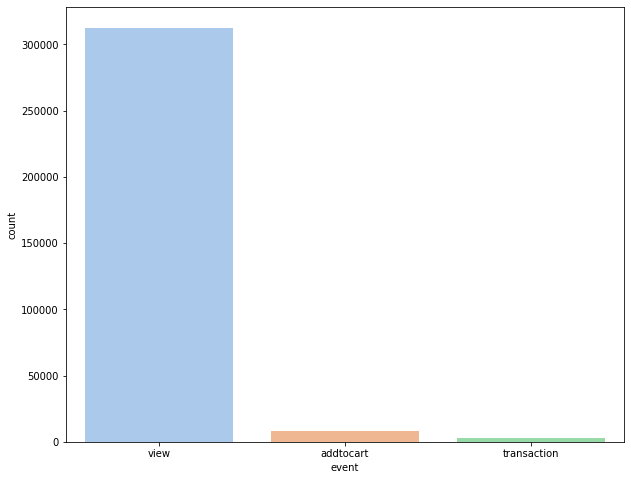

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 8)) # The figsize of the sample data in inches
sns.countplot(x='event',
              data=events,
              palette="pastel")

Convert the date and time format and show a sample

In [ ]:
import datetime
times =[]
for i in items['timestamp']:
    times.append(datetime.datetime.fromtimestamp(i//1000.0)) 

In [ ]:
items['timestamp'] = times
items.sample(15)

,timestamp,itemid,property,value
5056163,2015-05-10 03:00:00,311176.0,678,888666 779157
9458420,2015-05-10 03:00:00,152261.0,790,n51960.000
8886030,2015-06-07 03:00:00,157898.0,283,1283144 353870 367680 1007677 257374 323062 30...
2658996,2015-06-28 03:00:00,109875.0,917,1247872 n18151128.000
897701,2015-05-10 03:00:00,303041.0,159,519769
6934839,2015-06-28 03:00:00,40953.0,888,1252719 253573 339009 75026
5122569,2015-06-14 03:00:00,203326.0,888,82788 606598 1169762 1145548 893197
5489447,2015-06-28 03:00:00,287367.0,678,1180441
6289951,2015-06-07 03:00:00,204559.0,719,1001974 593897
4401680,2015-05-17 03:00:00,93905.0,587,838621 1160792 231473


event
addtocart        69332
transaction      22457
view           2664312
Name: event, dtype: int64


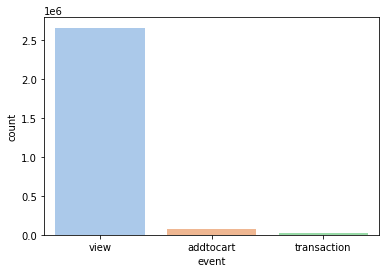

In [ ]:
print(events.groupby(['event']).event.count())
sns.countplot(x= 'event', data=events, palette="pastel")

Plot a pie chart of the data

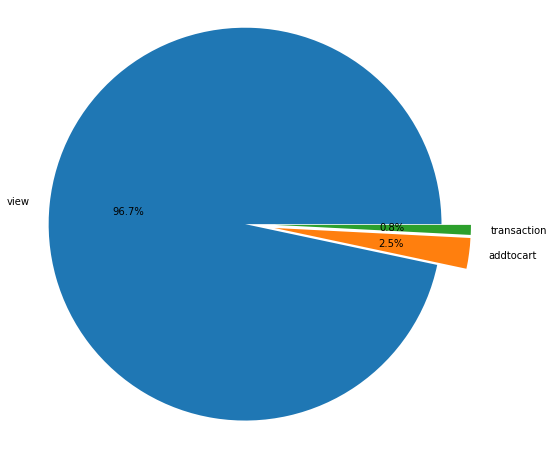

In [ ]:
data = events.event.value_counts()
labels = data.index
sizes = data.values
explode = (0, 0.15, 0.15)  # explode 1st slice
plt.subplots(figsize=(8,8))

# Plot
plt.pie(sizes, explode=explode, labels=labels,autopct='%1.1f%%', shadow=False, startangle=0)
plt.axis('equal')
plt.show()

##  Access and load the data for the "events" file

In [ ]:
events = pd.read_csv("/content/drive/MyDrive/FinalProj/RetailRocket/events.csv")
events.sample(15)

,timestamp,visitorid,event,itemid,transactionid
2728313,1438313905837,1024566,addtocart,218794,NaN
923075,1439949340282,781322,view,355043,NaN
978802,1440192312253,1000589,view,195143,NaN
999695,1440229295482,423611,view,348157,NaN
2740475,1438380205803,67368,view,80435,NaN
1793403,1432000028489,904963,view,397236,NaN
17655,1433177601944,387360,view,445380,NaN
1975479,1432748993850,258487,view,6190,NaN
622322,1438469128577,946457,view,347172,NaN
1672342,1431559787594,621585,view,428896,NaN


##  Access and load the data for the "category_tree" file

In [ ]:
category_tree = pd.read_csv("/content/drive/MyDrive/FinalProj/RetailRocket/category_tree.csv")
category_tree.head(15)



,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0
5,231,NaN
6,542,378.0
7,1146,542.0
8,1140,542.0
9,1479,1537.0


In [ ]:
items.loc[(items.property=='categoryid')&(items.value == '963')].sort_values('timestamp').head()

,timestamp,itemid,property,value
9221349,1431226800000,256490.0,categoryid,963
7821331,1431226800000,453236.0,categoryid,963
5412054,1431226800000,357145.0,categoryid,963
4197263,1431226800000,293586.0,categoryid,963
7790332,1431226800000,145221.0,categoryid,963


In [ ]:
# Show total of all visitors
print('Total visitors:', events['visitorid'].size)

Total visitors: 2756101


In [ ]:
# Show total of all unique visitors
all_customers = events['visitorid'].unique()
print("Unique visitors:", all_customers.size)

Unique visitors: 1407580


In [ ]:
# Show total of customers who purchased something

customer_purchased = events[events.transactionid.notnull()].visitorid.unique()
customer_purchased.size

11719

In [ ]:
# Show total of customers who browsed but did not purchase
customer_browsed = [x for x in all_customers if x not in customer_purchased]
len(customer_browsed)

1395861

In [ ]:
items_new = items.loc[items.property.isin(['categoryid', 'available']), :]

print("items with categoryid and available as property:", items_new.size)
items_new.head(10)

items with categoryid and available as property: 8736172


,timestamp,itemid,property,value
0,1435460400000,460429.0,categoryid,1338
5,1436065200000,285026.0,available,0
15,1437274800000,186518.0,available,0
79,1433646000000,423682.0,available,0
82,1434250800000,316253.0,available,1
96,1437274800000,430459.0,available,0
101,1433041200000,411262.0,available,0
116,1441508400000,50372.0,available,0
119,1441508400000,289043.0,available,0
133,1435460400000,365407.0,available,0


In [ ]:
# Group itemid by the event type
grouped = events.groupby('event')['itemid'].apply(list)
grouped

event
addtocart      [5206, 10572, 255275, 356475, 312728, 63312, 1...
transaction    [356475, 15335, 81345, 150318, 310791, 54058, ...
view           [355908, 248676, 318965, 253185, 367447, 22556...
Name: itemid, dtype: object

Check "most viewed" items and plot a bar chart

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


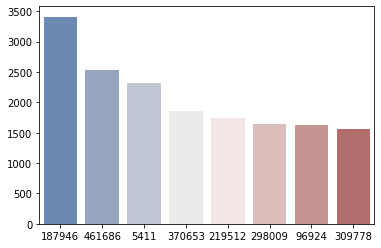

In [ ]:
import operator

views = grouped['view']
count_view ={}
views = np.array(views[:])
unique, counts = np.unique(views, return_counts=True)
count_view = dict(zip(unique, counts))

sort_count_view = sorted(count_view.items(), key = operator.itemgetter(1), reverse = True)
x = [i[0] for i in sort_count_view[:8]]
y = [i[1] for i in sort_count_view[:8]]
sns.barplot(x, y, order=x, palette="vlag")

Check "transaction" items and plot a bar chart

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


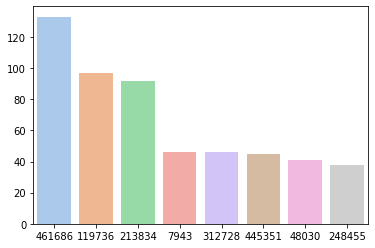

In [ ]:
transaction = grouped['transaction']
count_transaction ={}
transaction = np.array(transaction[:])
unique, counts = np.unique(transaction, return_counts=True)
count_transaction = dict(zip(unique, counts))

sort_count_transaction = sorted(count_transaction.items(), key = operator.itemgetter(1), reverse = True)
x = [i[0] for i in sort_count_transaction[:8]]
y = [i[1] for i in sort_count_transaction[:8]]
sns.barplot(x, y, order=x, palette="pastel")

Check "addtocart" items and plot a bar chart

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


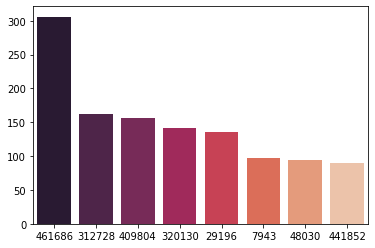

In [ ]:
addtocart = grouped['addtocart']
count_addtocart ={}
addtocart = np.array(addtocart[:])
unique, counts = np.unique(addtocart, return_counts=True)
count_addtocart = dict(zip(unique, counts))

sort_count_addtocart = sorted(count_addtocart.items(), key = operator.itemgetter(1), reverse = True)
x = [i[0] for i in sort_count_addtocart[:8]]
y = [i[1] for i in sort_count_addtocart[:8]]
sns.barplot(x, y, order=x, palette="rocket")

In [ ]:
# Analyze the 312728 itemid
events.loc[(events.itemid==312728)]

,timestamp,visitorid,event,itemid,transactionid
179,1433220880956,105775,addtocart,312728,NaN
2175,1433211031906,37093,view,312728,NaN
4001,1433216331395,301960,addtocart,312728,NaN
4581,1433221003460,105775,view,312728,NaN
7876,1433186863702,1245514,view,312728,NaN
...,...,...,...,...,...
2737060,1438272396067,901080,view,312728,NaN
2739839,1438358858548,1051054,addtocart,312728,NaN
2754127,1438367923670,977158,view,312728,NaN
2755593,1438358847786,1051054,view,312728,NaN


In [ ]:
# Create list of visitors who made a purchase and the purchased items
customer_purchased = events[events.transactionid.notnull()].visitorid.unique()
purchased_items = []

for customer in customer_purchased:
    purchased_items.append(list(events.loc[(events.visitorid == customer) & (events.transactionid.notnull())].itemid.values))

In [ ]:
purchased_items[:8]

[[356475],
 [15335,
  380775,
  237753,
  317178,
  12836,
  400969,
  105792,
  25353,
  200793,
  80582,
  302422],
 [81345],
 [150318, 49521],
 [310791, 299044],
 [54058,
  284871,
  251130,
  268335,
  183049,
  261940,
  369093,
  370745,
  192990,
  277119,
  241716,
  283766,
  16417,
  217068,
  36372,
  68923,
  428015,
  69533,
  13520,
  385638,
  442871,
  136526,
  247862,
  93828,
  230911,
  382595,
  34853,
  216260,
  154812,
  445241,
  57702,
  347850,
  151855,
  226327,
  288525,
  51354,
  345994,
  170438,
  254301,
  266439,
  193718,
  388558,
  26745,
  184086,
  79956,
  252040,
  82232,
  309821,
  394518,
  462070,
  331980,
  353111,
  200527,
  235933,
  68532,
  358882,
  60012,
  29741,
  270487,
  163689,
  6913,
  156457,
  341578,
  163352,
  234493,
  135174,
  452481,
  241755,
  56323,
  210137,
  184397,
  285202,
  198690,
  195958,
  239210,
  71640,
  189108,
  369112,
  346186,
  211207,
  134330,
  257070,
  302239,
  459480,
  57577,
  1952

Function for showing items bought by the same customer.

In [ ]:
def recommend_items(item_id, purchased_items):
    recommendation_list =[]
    for x in purchased_items:
        if item_id in x:
            recommendation_list +=x
    recommendation_list = list(set(recommendation_list) - set([item_id]))
    return recommendation_list

Recommend items when a visitor is views item_id = 404129

In [ ]:
recommend_items(404129, purchased_items)

[222208,
 6913,
 56323,
 135174,
 211207,
 183049,
 288525,
 234255,
 285202,
 442131,
 36372,
 184086,
 226327,
 163352,
 394518,
 170262,
 16417,
 198690,
 34853,
 156457,
 54058,
 29741,
 257070,
 268335,
 151855,
 200242,
 241716,
 261940,
 247862,
 302391,
 82232,
 370745,
 445241,
 68923,
 309821,
 341578,
 346186,
 374092,
 184397,
 136526,
 200527,
 361554,
 79956,
 353111,
 241755,
 254301,
 215904,
 264801,
 442725,
 385638,
 57702,
 163689,
 239210,
 60012,
 372845,
 283766,
 195958,
 249207,
 26745,
 259964,
 277119,
 9087,
 452481,
 382595,
 93828,
 252040,
 94344,
 345994,
 270487,
 51354,
 85914,
 69533,
 235933,
 302239,
 195234,
 204209,
 332721,
 189108,
 68532,
 193718,
 134330,
 154812,
 216260,
 369093,
 170438,
 284871,
 266439,
 229577,
 347850,
 331980,
 388558,
 13520,
 23251,
 459480,
 210137,
 71640,
 369112,
 206809,
 192990,
 358882,
 214757,
 57577,
 217068,
 428015,
 462070,
 442871,
 251130,
 234493,
 230911]

In [ ]:
events.head(10)

,visitorid,itemid,event,date
0,689859,421640,view,2015-05-03
1,935582,203248,view,2015-05-03
2,696326,194830,view,2015-05-03
3,131668,395045,view,2015-05-03
4,595484,129111,view,2015-05-03
5,596477,233611,view,2015-05-03
6,1224313,68470,view,2015-05-03
7,412359,77602,view,2015-05-03
8,1020587,146763,view,2015-05-03
9,959467,243898,view,2015-05-03


Install LightFM to be used for modeling

In [ ]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 14.6 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp38-cp38-linux_x86_64.whl size=747385 sha256=f550399a51f46e7d757b57cfd814dbd82d72cd52e110758ce42db881fa855b9b
  Stored in directory: /root/.cache/pip/wheels/ec/bb/51/9c487d021c1373b691d13cadca0b65b6852627b1f3f43550fa
Successfully built lightfm


Import necessary libraries for modeling

In [ ]:
from lightfm import LightFM
from lightfm.evaluation import auc_score
from scipy.sparse import coo_matrix
from sklearn import preprocessing

In [ ]:
events = events.assign(date=pd.Series(datetime.datetime.fromtimestamp(i/1000).date() for i in events.timestamp))
events = events.sort_values('date').reset_index(drop=True)
events = events[['visitorid','itemid','event', 'date']]
events.head(5)

AttributeError: ignored

In [ ]:
start_date = '2015-5-3'
end_date = '2015-5-18'
fd = lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').date()
events = events[(events.date >= fd(start_date)) & (events.date <= fd(end_date))]

In [ ]:
split_point = int(np.round(events.shape[0]*0.8))
events_train = events.iloc[0:split_point]
events_test = events.iloc[split_point::]
events_test = events_test[(events_test['visitorid'].isin(events_train['visitorid'])) & (events_test['itemid'].isin(events_train['itemid']))]

In [ ]:
id_cols=['visitorid','itemid']
trans_cat_train=dict()
trans_cat_test=dict()

for k in id_cols:
    cate_enc=preprocessing.LabelEncoder()
    trans_cat_train[k]=cate_enc.fit_transform(events_train[k].values)
    trans_cat_test[k]=cate_enc.transform(events_test[k].values)

In [ ]:
ratings = dict()

cate_enc=preprocessing.LabelEncoder()
ratings['train'] = cate_enc.fit_transform(events_train.event)
ratings['test'] = cate_enc.transform(events_test.event)

In [ ]:
n_users=len(np.unique(trans_cat_train['visitorid']))
n_items=len(np.unique(trans_cat_train['itemid']))

In [ ]:
rate_matrix = dict()
rate_matrix['train'] = coo_matrix((ratings['train'], (trans_cat_train['visitorid'], trans_cat_train['itemid'])), shape=(n_users,n_items))
rate_matrix['test'] = coo_matrix((ratings['test'], (trans_cat_test['visitorid'], trans_cat_test['itemid'])), shape=(n_users,n_items))

In [ ]:
model = LightFM(no_components=10, loss='warp')
model.fit(rate_matrix['train'], epochs=50, num_threads=10)

# Metric: Area Under ROC Curve (AUC)
AUC measures the likelihood that a random relevant item is ranked higher than a random irrelevant item. Higher the likelihood of this happening implies a higher AUC score meaning a better recommendation system.

We calculate this likelihood empirically based on the ranks given by the algorithm to all items — out of all possible pairs of type (relevant-item, non-relevant-item), AUC is a proportion of pairs where relevant-item was ranked higher than the irrelevant item from that pair.




https://drive.google.com/uc?id=1QE286jpRYXR4xlxjrgCufOCb1BvqnI5T

In [ ]:
auc_score(model, rate_matrix['train'], num_threads=10).mean()

0.9973406

In [ ]:
auc_score(model, rate_matrix['test'], num_threads=10).mean()

0.82500917

**> Additional Sources**

(1) https://www.kaggle.com/code/faridsharaf/ecommerce-recommendation-using-lfm 

(2) Krichene, W. & Rendle, S. "On Sampled Metrics for Item Recommendation". *Proceedings of the 26th ACM SIGKDD Conference on Knowledge Discovery and Data Mining (KDD ’20)*, August 23–27, 2020. https://dl.acm.org/doi/pdf/10.1145/3394486.3403226

(3) https://www.kaggle.com/code/johnosorio/retail-rocket-ecommerce-recommender-system

(4) "Classification: ROC Curve and AUC". https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc 

(5) Kirk, J. "Using LightFM to Recommend Projects to Consultants".https://medium.com/product-at-catalant-technologies/using-lightfm-to-recommend-projects-to-consultants-44084df7321c#.gu887ky51

(6) Kula, M. "Metadata Embeddings for User and Item Cold-start Recommendations". http://ceur-ws.org/Vol-1448/paper4.pdf

(7) https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset